# Correlation, Regression and Multicollinearity

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

As usual start by importing our dataset:

In [28]:
df = pd.read_csv('health_data.txt', delimiter='\t')
print(len(df), df.columns)
df.head()

20 Index(['Pt', 'BP', 'Age', 'Weight', 'BSA', 'Dur', 'Pulse', 'Stress'], dtype='object')


,Pt,BP,Age,Weight,BSA,Dur,Pulse,Stress
0,1,105,47,85.4,1.75,5.1,63,33
1,2,115,49,94.2,2.10,3.8,70,14
2,3,116,49,95.3,1.98,8.2,72,10
3,4,117,50,94.7,2.01,5.8,73,99
4,5,112,51,89.4,1.89,7.0,72,95


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a30acfa90>,
      dtype=object)

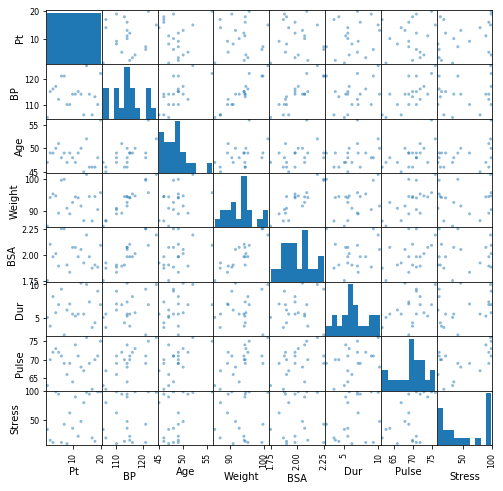

In [30]:
pd.plotting.scatter_matrix(df, figsize=(8,8))

## Correlation
As we can see, there's quite a bit of correlated features here!  
We can also further investigate a single relationship between two variables with the **plt.scatter(x,y)** method or calculte the pearson correlation coefficient with numpy's built in **np.corrcoeff()** method:

[[1.         0.95006765]
 [0.95006765 1.        ]]


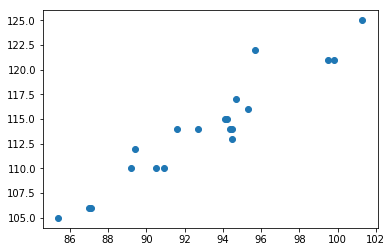

In [31]:
x , y = df.Weight, df.BP
print(np.corrcoef(x,y))
plt.scatter(x,y)

## Correlation versus causation
As you may have heard before, correlation does not equal causation. One fun example of this is ice cream sales and shark attacks. We have a bizarre dataset recording ice cream sales and shark attacks on given days at various beach towns, and plotting the two we notice a distinct correlation between the two. This does not mean that more ice sales causes more shark attacks to happen. In this case, both variables (ice cream sales and shark attacks) are correlated with a third feature we have yet to examine: temperature. In summer, as the temperature rises, both ice cream sales and shark attacks increase while in winter, there are comparitively few of both. In sum, don't assume that just because two variables are correlated that there is any direct causal relation between the two.

## Multicollinearity
Multicollinearity is when we have multiple predictive variables which are highly correlated. This leads to a number of issues when we then go to perform regression (which we will investigate in more depth!) 

In our current example, Blood Pressure and Weight were highly correlated which will greatly impact our regression analysis. Let's investigate this briefly.

# Regression

In [60]:
from sklearn.linear_model import LinearRegression

#Define X and y
X = df[['Pt', 'Age', 'Weight', 'BSA', 'Dur', 'Pulse', 'Stress']]
y = df['BP']
#Initialize a regression object
linreg = LinearRegression()

#Fit the model
linreg.fit(X, y)

#Use the model to predict outputs
df['Estimated BP'] = linreg.predict(X)

#Calculate Errors (also called residuals)
df['Residuals'] = df['Estimated BP'] - df['BP']

#Print the model's R^2 to measure overall performance
print('R^2 model score:', linreg.score(X,y), '\n')

#Print the coefficients for the model's formula
print('Model feature coefficients:')
weight_dict = dict(zip(X.columns, linreg.coef_))
for feat, coeff in list(zip(X.columns, linreg.coef_)):
    print(feat, 'Coefficient weight: {}'.format(round(coeff, 4)))

R^2 model score: 0.9962701462782667 

Model feature coefficients:
Pt Coefficient weight: -0.011
Age Coefficient weight: 0.7018
Weight Coefficient weight: 0.9778
BSA Coefficient weight: 3.6165
Dur Coefficient weight: 0.072
Pulse Coefficient weight: -0.0902
Stress Coefficient weight: 0.0064


# Problems with multicollinearity
There are a few considerations to keep in mind when it comes to interpreting regression models based on underlying data with multicollinearity. *One is that the coefficients in the model themselves lose interpretability.* Under ideal conditions, we would like to interpret our coefficients literally. For example, the coefficient associated with weight is 0.9778. If this coefficient were stable, we could say something along the lines "as a person's weight goes up by 1, there blood pressure goes up by 0.9778. Unfortunately, with multicollinearity, we cannot make such claims. That is because the coefficients associated with weights that are highly correlated may vary widely. For example, observe what happens to the coefficient associated with weight when we remove the highly correlated feature BSA:

In [61]:
from sklearn.linear_model import LinearRegression

#Define X and y
X = df[['Pt', 'Age', 'Weight', 'Dur', 'Pulse', 'Stress']] #'BSA' removed.
y = df['BP']
#Initialize a regression object
linreg = LinearRegression()

#Fit the model
linreg.fit(X, y)

#Use the model to predict outputs
df['Estimated BP'] = linreg.predict(X)

#Calculate Errors (also called residuals)
df['Residuals'] = df['Estimated BP'] - df['BP']

#Print the model's R^2 to measure overall performance
print('R^2 model score:', linreg.score(X,y), '\n')

#Save results
new_weight_dict = dict(zip(X.columns, linreg.coef_))

#Print the coefficients for the model's formula
print('Model feature coefficients:')
for feat, coeff in list(zip(X.columns, linreg.coef_)):
    print(feat, 'Coefficient weight: {}'.format(round(coeff, 4)))


R^2 model score: 0.9947573091859482 

Model feature coefficients:
Pt Coefficient weight: -0.0172
Age Coefficient weight: 0.7278
Weight Coefficient weight: 1.1027
Dur Coefficient weight: 0.07
Pulse Coefficient weight: -0.1428
Stress Coefficient weight: 0.0086


In [65]:
weights = pd.DataFrame.from_dict(weight_dict, orient='index').reset_index()
weights.columns = ['Feature', 'Original Weight']
weights['New Weight'] = weights.Feature.map(new_weight_dict)
weights['Change'] = np.abs(weights['New Weight'] - weights['Original Weight']) #Net change (absolute value)
weights = weights.sort_values(by='Change', ascending=False)
weights['BSA Corr'] = weights.Feature.map(lambda feat: np.corrcoef(df.BSA, df[feat])[0][1])
weights

,Feature,Original Weight,New Weight,Change,BSA Corr
2,Weight,0.977808,1.102730,0.124922,0.875305
5,Pulse,-0.090189,-0.142836,0.052647,0.464819
1,Age,0.701830,0.727818,0.025989,0.378455
0,Pt,-0.011031,-0.017190,0.006159,-0.031288
6,Stress,0.006422,0.008632,0.002210,0.018446
4,Dur,0.071956,0.069955,0.002000,0.130540
3,BSA,3.616457,NaN,NaN,1.000000


What this goes to demonstrate is that some of these coefficients are unstable and depend on what other features are incorporated into the model. Adding additional features that are correlated with features already added will never reduce the overall performance of the model, but can be thought of as 'not adding much new information'. In this way, adding correlated features is unlikely to drastically increase model performance to any substantial degree. This also makes it difficult to judge the importance of a particular variable; the importance of the variable depends on what variables are already present (if other variables already exist which are highly correlated, then the variable will again add little predictive information).

# Try it
Iterate through the remaining columns and successively remove features from the model. Record what happens to the R^2 of the model and the various coefficients.

In [ ]:
#Your code here

# Normalization
Another important factor can be the scale of your various features. Simply having one feature that is on a much larger scale then others can bloat its signifigance to some training algorithms. For example, the weight feature has a much larger numerical scale then the BSA feature column. To standardize this, a common technique is to normalize all columns to have a minimum of zero and a maximum on one. An easy way to do this is:  
$\frac{value - minimum}{maximum - minimum}$

In [67]:
df = pd.read_csv('health_data.txt', delimiter='\t')
print(len(df), df.columns)
df.head()

20 Index(['Pt', 'BP', 'Age', 'Weight', 'BSA', 'Dur', 'Pulse', 'Stress'], dtype='object')


,Pt,BP,Age,Weight,BSA,Dur,Pulse,Stress
0,1,105,47,85.4,1.75,5.1,63,33
1,2,115,49,94.2,2.10,3.8,70,14
2,3,116,49,95.3,1.98,8.2,72,10
3,4,117,50,94.7,2.01,5.8,73,99
4,5,112,51,89.4,1.89,7.0,72,95


# Try it out!
Iterate over the columns and normalize each to have a minimum of zero and maximum of one by applying a lambda function that subtracts the minimum and divides by the range.  
$\frac{value - minimum}{maximum - minimum}$

In [ ]:
#Your code here